In [220]:
#import libraries

import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.patches import Arc, Circle, Rectangle
import itertools

from PIL import Image
import time


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression

from sklearn import metrics

from sklearn.metrics import confusion_matrix
import itertools

from sklearn.model_selection import GridSearchCV

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

import xgboost as xgb

import seaborn as sns
sns.set(context='paper', style='darkgrid', rc={'figure.facecolor':'white'}, font_scale=1.2)

import pickle

pd.options.mode.chained_assignment = None


In [180]:
# reading in csv file

df = pd.read_csv('Final_df.csv', index_col = 0)

In [181]:
# removing the 3 multiposition players as they do not fit into the dataset

df = df[(df['Pos'] != 'PF-SF') & (df['Pos'] != 'SG-PG') & (df['Pos'] != 'SF-SG')]

In [182]:
# taking a look at the value counts

df.Pos.value_counts()

SG    426
PF    377
SF    375
PG    375
C     373
Name: Pos, dtype: int64

In [184]:
# creating the features and the target variables

X = df.drop(columns = ['Player', 'PLAYER_ID', 'Pos'])
y = df.Pos

# EDA

I am doing some eda to get an idea of what i have in my data and what patterns i might find. Also see if i can find data that may in fact be irrelevant

[Text(0, 0, '0'),
 Text(0, 0, '50000'),
 Text(0, 0, '100000'),
 Text(0, 0, '150000'),
 Text(0, 0, '200000'),
 Text(0, 0, '250000')]

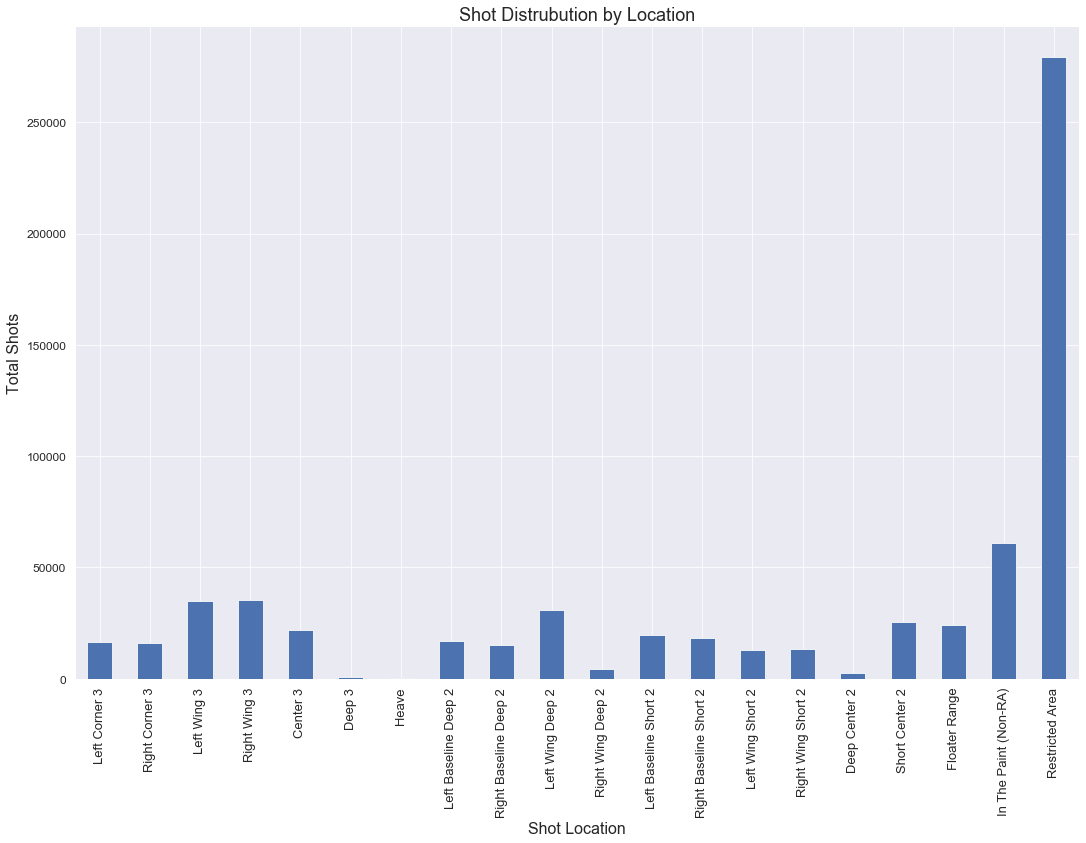

In [28]:
# graph showing the breakdown of the different shot locations

ax = X.sum()[:20].plot.bar(figsize = (18,12))

ax.set_title('Shot Distrubution by Location', fontdict = {'fontsize' : 18})
ax.set_ylabel('Total Shots', fontdict = {'fontsize' : 16})
ax.set_xlabel('Shot Location', fontdict = {'fontsize' : 16})
ax.set_xticklabels(['Left Corner 3', 'Right Corner 3', 'Left Wing 3', 'Right Wing 3', 'Center 3',
'Deep 3', 'Heave', 'Left Baseline Deep 2', 'Right Baseline Deep 2', 'Left Wing Deep 2', 
'Right Wing Deep 2', 'Left Baseline Short 2', 'Right Baseline Short 2', 'Left Wing Short 2',
'Right Wing Short 2', 'Deep Center 2', 'Short Center 2', 'Floater Range', 
'In The Paint (Non-RA)', 'Restricted Area'], fontdict = {'fontsize' : 13})
ax.set_yticklabels([0, 50000, 100000, 150000, 200000, 250000], fontdict = {'fontsize' : 12})

[Text(0, 0, '0'),
 Text(0, 0, '50000'),
 Text(0, 0, '100000'),
 Text(0, 0, '150000'),
 Text(0, 0, '200000'),
 Text(0, 0, '250000')]

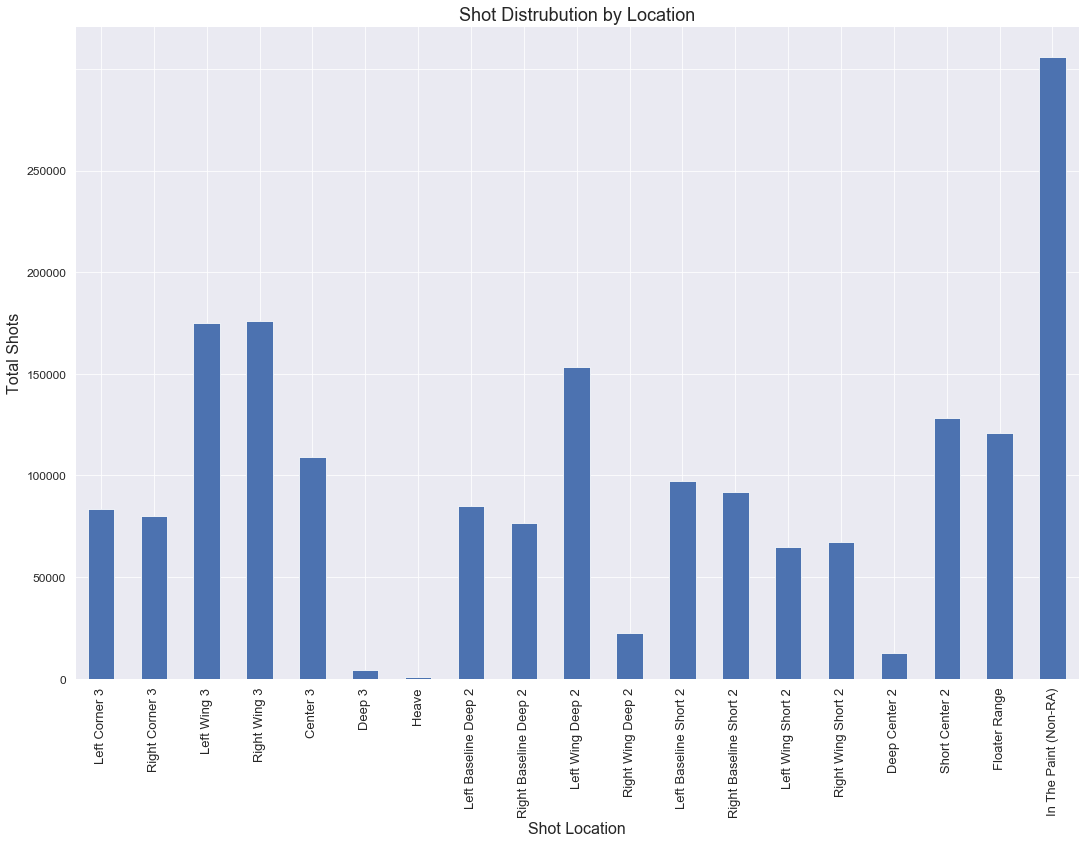

In [29]:
# Same breakdown but not including restricted area which is the large magority of shots

ax2 = X.sum()[:19].plot.bar(figsize = (18,12))

ax2.set_title('Shot Distrubution by Location', fontdict = {'fontsize' : 18})
ax2.set_ylabel('Total Shots', fontdict = {'fontsize' : 16})
ax2.set_xlabel('Shot Location', fontdict = {'fontsize' : 16})
ax2.set_xticklabels(['Left Corner 3', 'Right Corner 3', 'Left Wing 3', 'Right Wing 3', 'Center 3',
'Deep 3', 'Heave', 'Left Baseline Deep 2', 'Right Baseline Deep 2', 'Left Wing Deep 2', 
'Right Wing Deep 2', 'Left Baseline Short 2', 'Right Baseline Short 2', 'Left Wing Short 2',
'Right Wing Short 2', 'Deep Center 2', 'Short Center 2', 'Floater Range', 
'In The Paint (Non-RA)'], fontdict = {'fontsize' : 13})
ax2.set_yticklabels([0, 50000, 100000, 150000, 200000, 250000], fontdict = {'fontsize' : 12})

### Plotting points on a court

In [76]:
# getting the original x, y coordinates for the shots

shot_chart = pd.read_csv('2000-2020_shot_charts.csv')

In [106]:
# getting shot charts for 6 different players, 

# 2 guards, 1 star and 1 solid player
# 2 forwards, 1 star and 1 role player
# 2 bigs, 1 star and 1 less proficient big man

Harden = shot_chart[shot_chart.PLAYER_NAME == 'James Harden']
Crawford = shot_chart[shot_chart.PLAYER_NAME == 'Jamal Crawford']

Durant = shot_chart[shot_chart.PLAYER_NAME == 'Kevin Durant']
Tucker = shot_chart[shot_chart.PLAYER_NAME == 'P.J. Tucker'] 

Davis = shot_chart[shot_chart.PLAYER_NAME == 'Anthony Davis']
Deandre = shot_chart[shot_chart.PLAYER_NAME == 'DeAndre Jordan']


In [67]:
# drawing a court on matplotlib ->   http://savvastjortjoglou.com/nba-shot-sharts.html

def draw_court(ax=None, color='black', lw=2, outer_lines=False):
    # If an axes object isn't provided to plot onto, just get current one
    if ax is None:
        ax = plt.gca()

    # Create the various parts of an NBA basketball court

    # Create the basketball hoop
    # Diameter of a hoop is 18" so it has a radius of 9", which is a value
    # 7.5 in our coordinate system
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)

    # Create backboard
    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)

    # The paint
    # Create the outer box 0f the paint, width=16ft, height=19ft
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                          fill=False)
    # Create the inner box of the paint, widt=12ft, height=19ft
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False)

    # Create free throw top arc
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed')
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color)

    # Three point line
    # Create the side 3pt lines, they are 14ft long before they begin to arc
    corner_three_a = Rectangle((-220, -47.5), 0, 140, linewidth=lw,
                               color=color)
    corner_three_b = Rectangle((220, -47.5), 0, 140, linewidth=lw, color=color)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    # I just played around with the theta values until they lined up with the 
    # threes
    three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw,
                    color=color)

    # Center Court
    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color)

    # List of the court elements to be plotted onto the axes
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc, center_outer_arc,
                      center_inner_arc]

    if outer_lines:
        # Draw the half court line, baseline and side out bound lines
        outer_lines = Rectangle((-250, -47.5), 500, 470, linewidth=lw,
                                color=color, fill=False)
        court_elements.append(outer_lines)

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax

Plotting for 6 different player types explained earlier

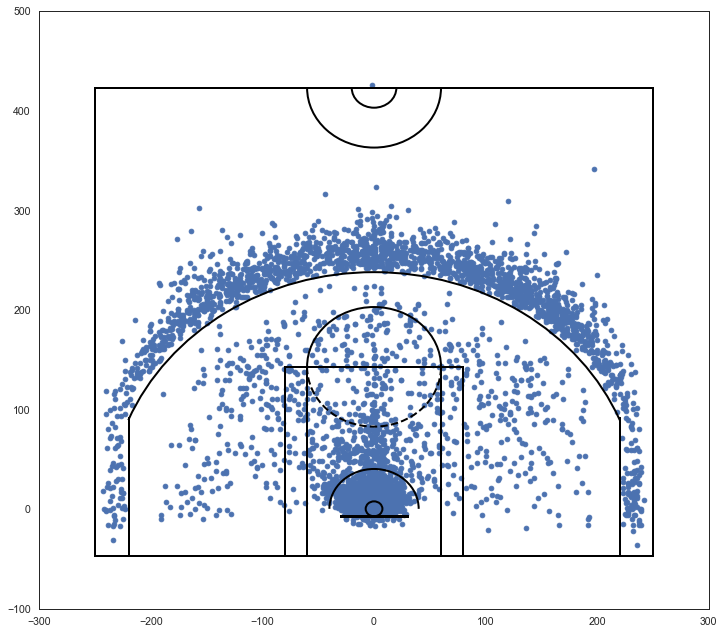

In [79]:
plt.figure(figsize=(12,11))
plt.scatter(Harden.LOC_X, Harden.LOC_Y)
draw_court(outer_lines=True)
plt.xlim(-300,300)
plt.ylim(-100,500)
plt.show()

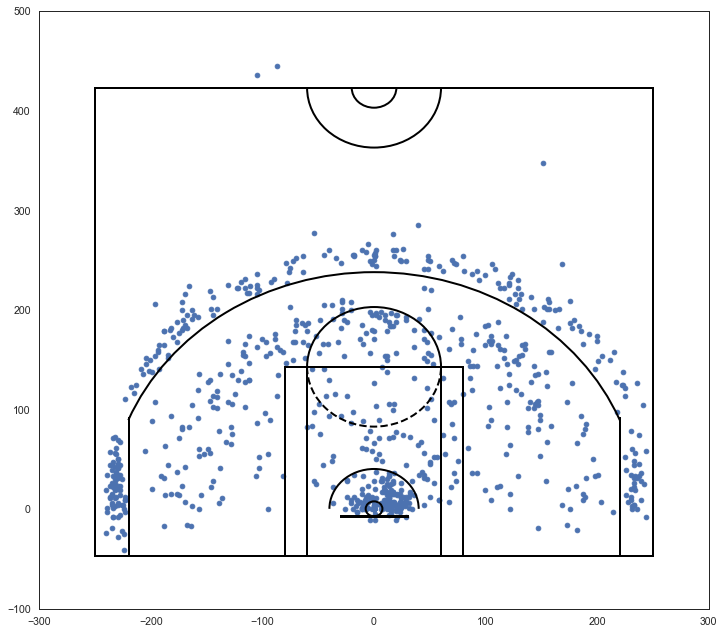

In [99]:
plt.figure(figsize=(12,11))
plt.scatter(Crawford.LOC_X, Crawford.LOC_Y)
draw_court(outer_lines=True)
plt.xlim(-300,300)
plt.ylim(-100,500)
plt.show()

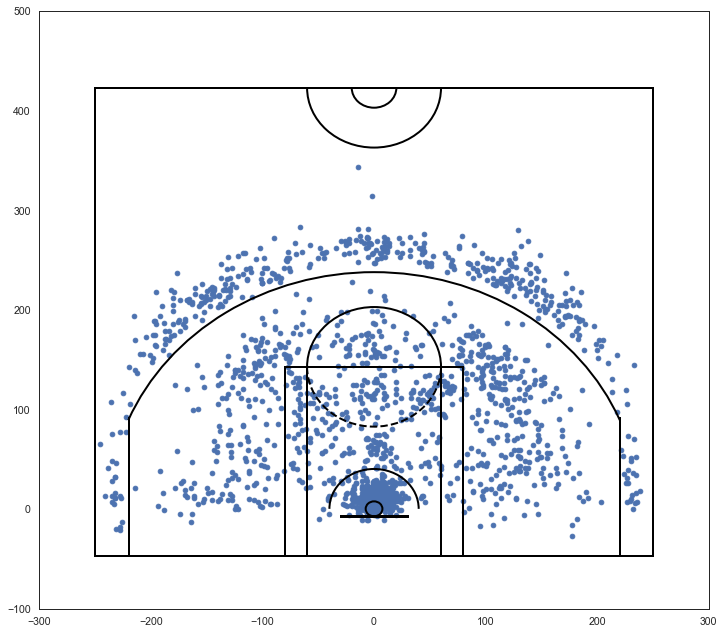

In [87]:
plt.figure(figsize=(12,11))
plt.scatter(Durant.LOC_X, Durant.LOC_Y)
draw_court(outer_lines=True)
plt.xlim(-300,300)
plt.ylim(-100,500)
plt.show()

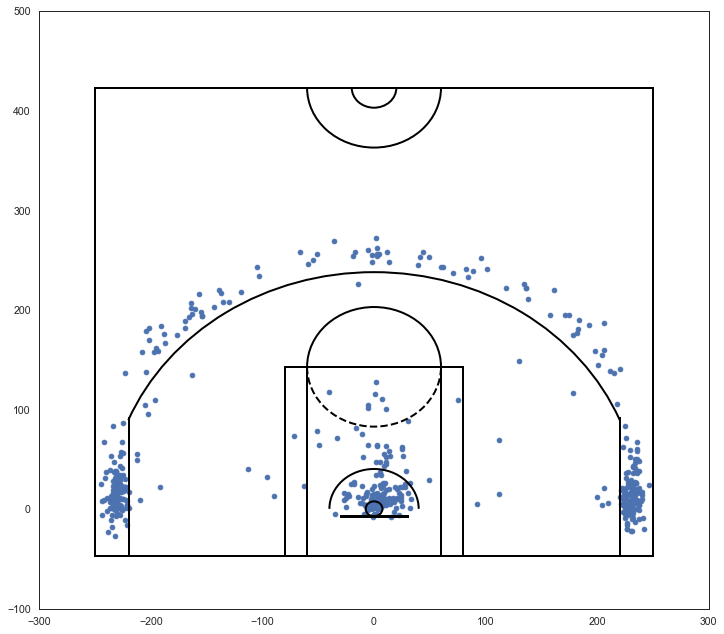

In [80]:
plt.figure(figsize=(12,11))
plt.scatter(Tucker.LOC_X, Tucker.LOC_Y)
draw_court(outer_lines=True)
plt.xlim(-300,300)
plt.ylim(-100,500)
plt.show()

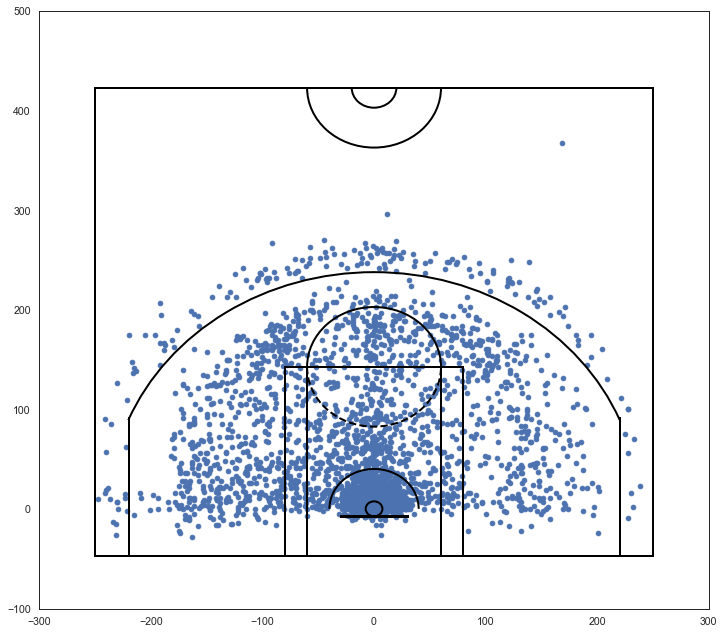

In [100]:
plt.figure(figsize=(12,11))
plt.scatter(Davis.LOC_X, Davis.LOC_Y)
draw_court(outer_lines=True)
plt.xlim(-300,300)
plt.ylim(-100,500)
plt.show()

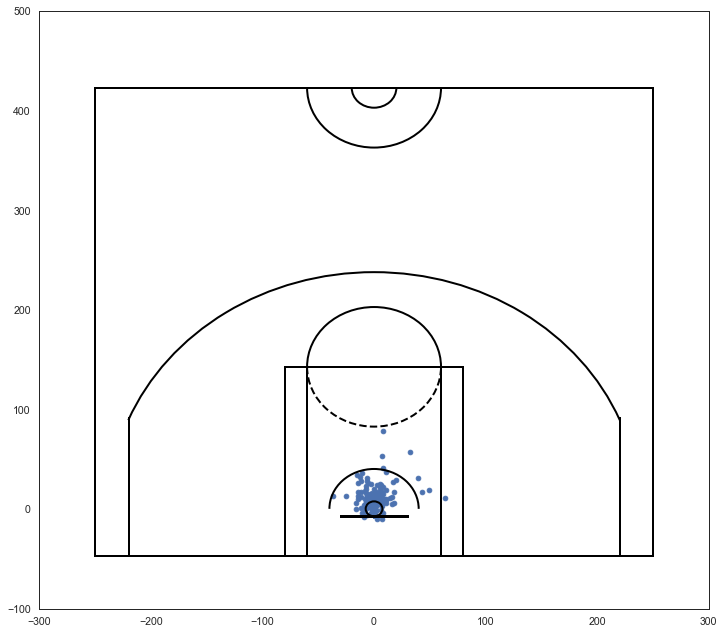

In [107]:
plt.figure(figsize=(12,11))
plt.scatter(Deandre.LOC_X, Deandre.LOC_Y)
draw_court(outer_lines=True)
plt.xlim(-300,300)
plt.ylim(-100,500)
plt.show()

# 5 classes

## Train Test Split

In [185]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 24, test_size = .25) 

## Dummy classifier

#### First run the dummy classifier to get an idea of what the number i need to beat should be

In [186]:
dummy_clf = DummyClassifier(strategy = 'most_frequent')

In [187]:
dummy_clf.fit(X_train, y_train)

DummyClassifier(constant=None, random_state=None, strategy='most_frequent')

In [188]:
dummy_pred = dummy_clf.predict(X_test)

In [189]:
accuracy_score(dummy_pred, y_test)

0.2074688796680498

# XGB

## XGBoost Model

In [195]:
xgb_clf = xgb.XGBClassifier()

In [196]:
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [197]:
xgb_pred = xgb_clf.predict(X_test)

accuracy_score(y_test, xgb_pred)

0.5746887966804979

## XGB Gridsearch

In [198]:
param_xgb = {'max_depth' : [4, 6, 8, 10], 'learning_rate' : [.01, .05, .1, .2],
             'n_estimators' : [100, 250, 500], 'min_child_weight' : [1,3,5]}

In [199]:
grid_xgb = GridSearchCV(xgb_clf, param_xgb, n_jobs = -1, cv = 3, verbose = 1)

grid_xgb.fit(X_train, y_train)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 432 out of 432 | elapsed:  6.0min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0, gpu_id=-1,
                                     importance_type='gain',
                                     interaction_constraints='',
                                     learning_rate=0.300000012,
                                     max_delta_step=0, max_depth=6,
                                     min_child_weight=1, missing=nan,
                                     monotone_constraints='()',
                                     n_estimators=100, n_job...
                                     reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=None, subsample=1,
                                     tree_method='exact', validate_parameters=1,
                                     verbosity=None),
          

In [259]:
grid_xgb_pred = grid_xgb.best_estimator_.predict(X_test)

accuracy_score(y_test, grid_xgb_pred)

0.5767634854771784

# Random Forest

## Random Forest Model

In [216]:
rf_clf = RandomForestClassifier()

In [217]:
rf_clf.fit(X_train, y_train)

rf_pred = rf_clf.predict(X_test)

accuracy_score(y_test, rf_pred)

0.5705394190871369

## Random Forest gridsearch

In [218]:
param_rfc = {'max_depth': [3, 6, 9, 12, 15], 'n_estimators' : [100, 200, 300, 400, 500], 
              'min_samples_leaf': [1, 2, 3], 'min_samples_split': [2, 4, 6], 'criterion': ['gini', 'entropy']}

In [219]:
grid_rf = GridSearchCV(rfc_clf, param_rfc, n_jobs = -1, cv = 5, scoring = 'accuracy')

grid_rf.fit(X_train, y_train)

0.5767634854771784

In [260]:
rf_grid_pred = grid_rf.best_estimator_.predict(X_test)

accuracy_score(y_test, rf_grid_pred)

0.5767634854771784

# SVM

## SVC Model - 

#### Need to rerun the model with scaled data

In [225]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scale = pd.DataFrame(data=scaler.transform(X_train), columns = X.columns)
X_test_scale = pd.DataFrame(data=scaler.transform(X_test), columns = X.columns)

In [264]:
sv_clf = SVC(kernel='linear')

In [265]:
sv_clf.fit(X_train_scale, y_train)

svc_pred = sv_clf.predict(X_test_scale)

accuracy_score(y_test, svc_pred)

0.6016597510373444

## SVC Gridsearch

In [262]:
param_svc = {'C': [.1, 1, 10, 100], 'gamma': ['auto']}

In [382]:
grid_svc = GridSearchCV(sv_clf, param_svc, refit = True, verbose = 1, n_jobs = -1, cv = 5)

grid_svc.fit(X_train_scale, y_train)


Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


KeyboardInterrupt: 

In [ ]:
svc_grid_pred = grid_svc.best_estimator_.predict(X_test_scale)

accuracy_score(y_test, svc_grid_pred)

# 4 Class 

### Problem is that the difference between sg and small forwards is too small that they are likely to get miss classified so i want to take the best model and only use 4 classes instead (pg, wing, pf and center)

In [268]:
new_positions = []

for x in df.Pos:
    if (x == 'SG') or (x == 'SF'):
        new_positions.append('Wing')
    else:
        new_positions.append(x)

In [270]:
df['new_pos'] = new_positions

In [271]:
X2 = df.drop(columns = ['Player', 'PLAYER_ID', 'Pos', 'new_pos'])
y2 = df.new_pos

## Train test split

In [272]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, random_state = 24, test_size = .25) 

In [273]:
scaler2 = StandardScaler()
scaler2.fit(X2_train)
X2_train_scale = pd.DataFrame(data=scaler2.transform(X2_train), columns = X2.columns)
X2_test_scale = pd.DataFrame(data=scaler2.transform(X2_test), columns = X2.columns)

## SVM

In [352]:
sv2_clf = SVC(kernel='rbf', C = 3, class_weight = 'balanced')

In [353]:
sv2_clf.fit(X2_train_scale, y2_train)

svc2_pred = sv2_clf.predict(X2_test_scale)

accuracy_score(y2_test, svc2_pred)

0.7178423236514523

# 3 Classes

## changing from 4 classes to 3 to attempt to do the same thing, since the data is coming from 2000-2020 then combining centers and pfs could easily prove to help the data the same way that sg and sf are since the small ball 4 didnt change until around 2015

In [354]:
new_positions2 = []

for x in df.Pos:
    if (x == 'PF') or (x == 'C'):
        new_positions2.append('Big')
    else:
        new_positions2.append(x)

In [355]:
df['new_pos2'] = new_positions2

In [356]:
X3 = df.drop(columns = ['Player', 'PLAYER_ID', 'Pos', 'new_pos', 'new_pos2'])
y3 = df.new_pos2

## Train test split

In [358]:
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, random_state = 24, test_size = .25) 

In [360]:
scaler3 = StandardScaler()
scaler3.fit(X3_train)
X3_train_scale = pd.DataFrame(data=scaler3.transform(X3_train), columns = X3.columns)
X3_test_scale = pd.DataFrame(data=scaler3.transform(X3_test), columns = X3.columns)

## SVM

In [380]:
sv3_clf = SVC(kernel='linear', C = 1, class_weight = None)

In [381]:
sv3_clf.fit(X3_train_scale, y3_train)

svc3_pred = sv3_clf.predict(X3_test_scale)

accuracy_score(y3_test, svc3_pred)

0.7157676348547718

### Finding Feature importance in svm model

In [385]:
def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()

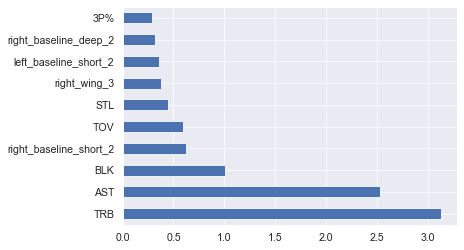

In [414]:
pd.Series(abs(sv3_clf.coef_[0]), index=X3.columns).nlargest(10).plot(kind='barh')

## Only using shot selection with 4 classes

In [391]:
df.columns

Index(['Player', 'PLAYER_ID', 'left_corner_3', 'right_corner_3', 'left_wing_3',
       'right_wing_3', 'center_3', 'deep_3', 'heave', 'left_baseline_deep_2',
       'right_baseline_deep_2', 'left_wing_deep_2', 'right_wing_deep_2',
       'left_baseline_short_2', 'right_baseline_short_2', 'left_wing_short_2',
       'right_wing_short_2', 'deep_center_2', 'short_center_2',
       'floater_range', 'in_the_paint', 'restricted_area', 'Pos', '3P%', '2P%',
       'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'new_pos', 'new_pos2'],
      dtype='object')

In [392]:
X4 = df.drop(columns = ['Player', 'PLAYER_ID', 'Pos', 'new_pos', 'new_pos2', '3P%', '2P%',
                       'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS'])
y4 = df.new_pos

In [393]:
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, random_state = 24, test_size = .25) 

In [394]:
scaler4 = StandardScaler()
scaler4.fit(X4_train)
X4_train_scale = pd.DataFrame(data=scaler4.transform(X4_train), columns = X4.columns)
X4_test_scale = pd.DataFrame(data=scaler4.transform(X4_test), columns = X4.columns)

## SVM

In [412]:
sv4_clf = SVC(kernel='linear', C = 2, class_weight = None)

In [413]:
sv4_clf.fit(X4_train_scale, y4_train)

svc4_pred = sv4_clf.predict(X4_test_scale)

accuracy_score(y4_test, svc4_pred)

0.4170124481327801

## Feature importance

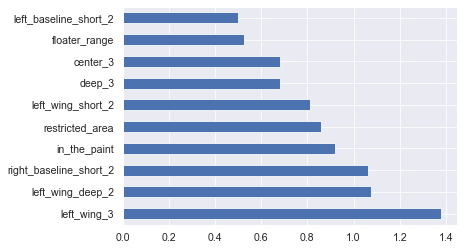

In [415]:
pd.Series(abs(sv4_clf.coef_[0]), index=X4.columns).nlargest(10).plot(kind='barh')

After running all the different models i found that just using shot locations for all the players does not do nearly as good of a job as adding in the box score models but some of the shot locations did affect the data and had a large influence on the data. 

- short right baseline (common shot location for bigs)
- left wing 3 & right wing 3 (common shot for most guards and wings)

- in the pain and restricted area also in the top 5 which are very much big men stats

but overall the features that had the biggest impact were still some of the basic box score stats like blocks, rebounds and assists. Blocks and rebounds being a big man dominant feature and assists being big for guards